In [63]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

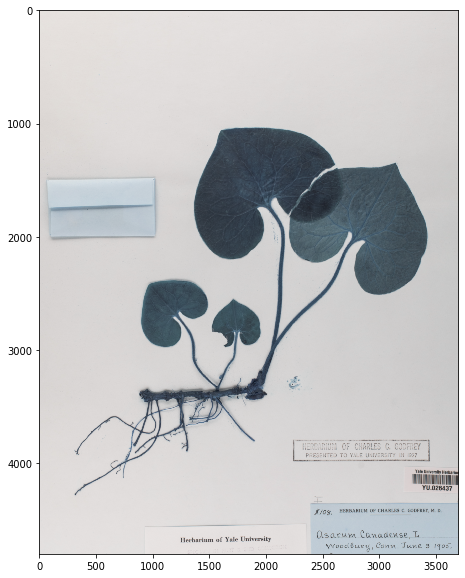

In [64]:
img = cv2.imread('leaf-ex-2.jpg')
#img = img[500:3000, 100:2500]
#img = img[1800:5000, 800:4500]
img = img[1000:5800, 800:4500]
blur = cv2.GaussianBlur(img, (21, 21), 2)
h, w = img.shape[:2]

fig = plt.figure(figsize=(10,10))
plt.imshow(blur)

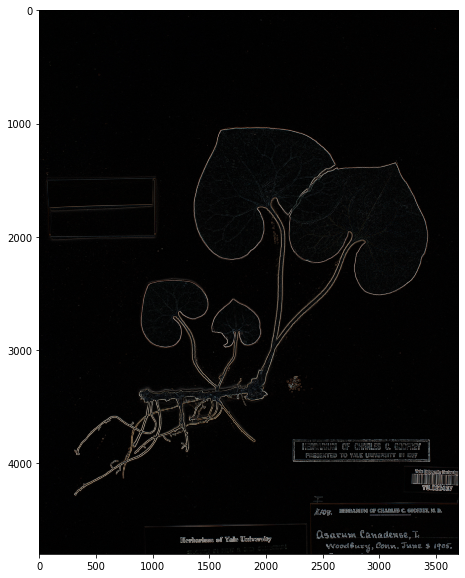

In [65]:
# Morphological gradient
# 1st: Ellipse shaped to put where 1's are 
# 2nd: kernel size
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))

# MORPH_GRADIENT = difference between erosion and dilation
# Will provide the outline of the leaves
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

fig = plt.figure(figsize=(10,10))
plt.imshow(gradient)

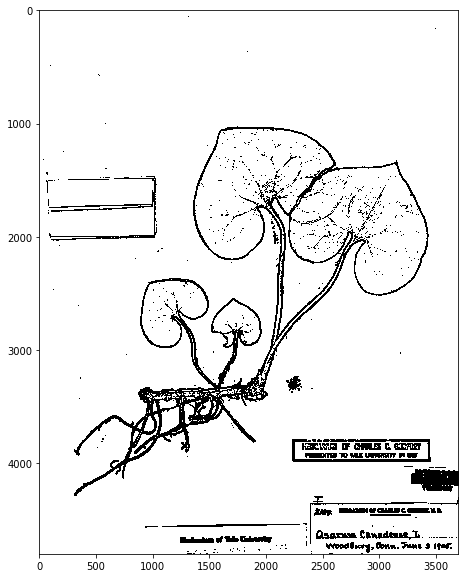

In [81]:
# Binarize gradient
lowerb = np.array([0, 0, 0])
uval = 15
upperb = np.array([uval, uval, uval])

# ?? Creates the mask to threshold for what is edges 
# inRange: Thresholds to get certain colors -> in this case, thresholding to 
#     find edges
binary = cv2.inRange(gradient, lowerb, upperb)

fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

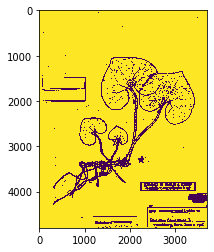

In [82]:
# NEW CODE
#contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#binary = cv2.drawContours(binary, contours, -1, (0, 255, 0), 3) 
#plt.imshow(binary)

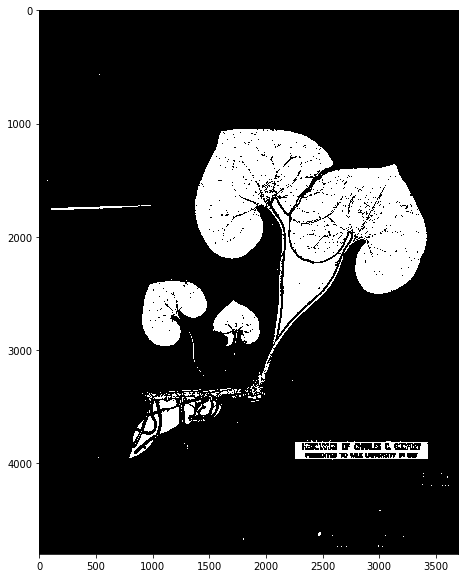

In [67]:
# Flood fill from the edges to remove edge crystals 
# From my understanding, the code below removes edges where we aren't sure 
#      where it ends (i.e. things at the edge of the image)
# Not sure if we will need this since we don't have any leaves at the edges of 
#      an image

for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)
        
for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

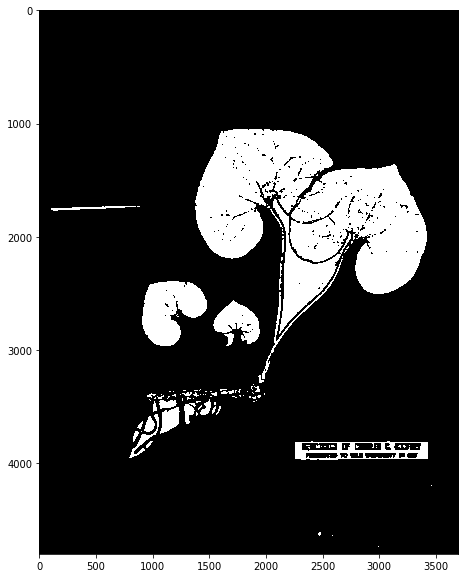

In [68]:
# Cleaning up mask

# Erosion: erodes away the boundaries of foreground object 
# Thickness of the foreground decreases -> less white

# Dilation: increases white region in the image; size of foreground object 
# increases

# Open: Erosion followed by Dilation; good to remove noise outside of image
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Close: Dilation followed by Erosion; good to remove small holes inside of image
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

# Cleans up foreground
fig = plt.figure(figsize=(10,10))
plt.imshow(foreground, cmap = 'gray')

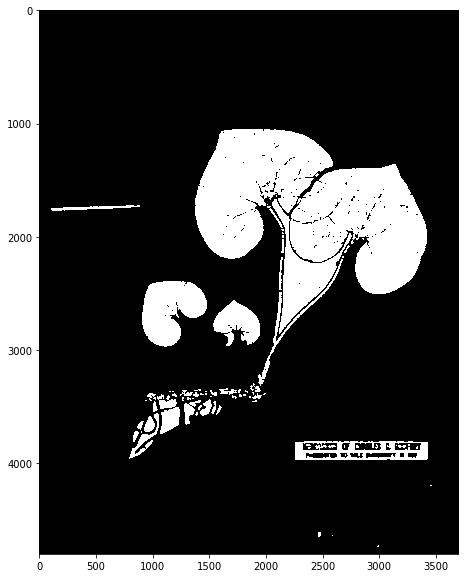

In [69]:
# Creating background and unknown mask for labeling

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)

fig = plt.figure(figsize=(10,10))

plt.imshow(background, cmap = 'gray')

In [70]:
# Watershed

# Computes the connected components labeled image of boolean image 
# Outputs total number of labels; 0 = background
markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

In [106]:
np.unique(markers)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113], dtype=int32)

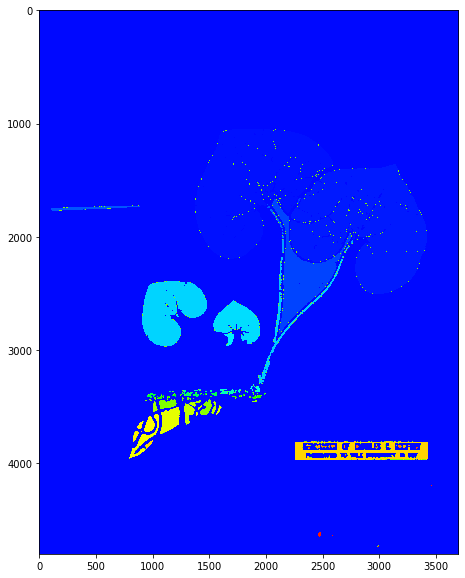

In [99]:
# Assign the markers a hue between 0 and hue_max
hue_max = 120
hue_markers = np.uint8(hue_max*np.float32(markers)/np.max(markers))

blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

fig = plt.figure(figsize=(10,10))
plt.imshow(marker_img)

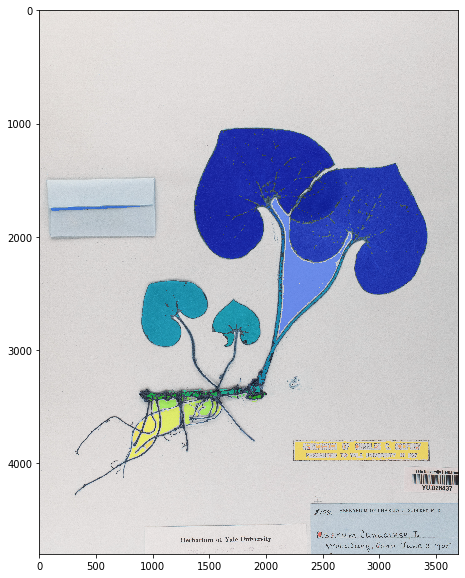

In [100]:
# Label the original image with the watershed markers

labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(labeled_img)

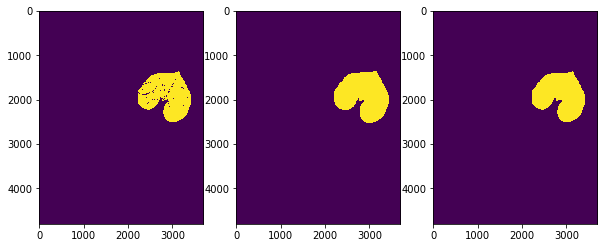

In [139]:
img2 = img.copy()
markers1 = ((markers == 3)).astype(np.uint8)
ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) 
dm2 = cv2.dilate(m2, kernel, iterations=6)
em2 = cv2.erode(dm2, kernel, iterations=6)
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
ax0.imshow(m2)
ax1.imshow(dm2)
ax2.imshow(em2)

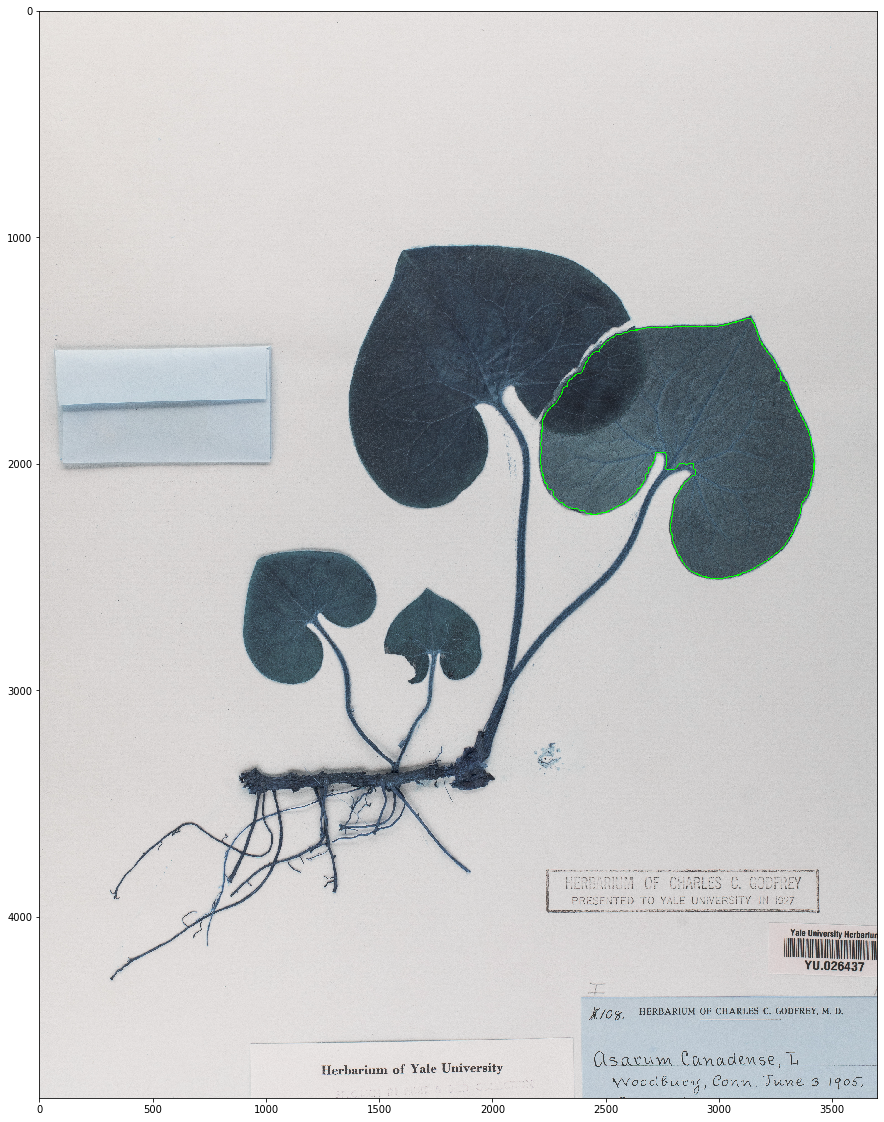

In [140]:
contours, hierarchy = cv2.findContours(em2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in contours:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 3)

fig = plt.figure(figsize=(20,20))
plt.imshow(img2)

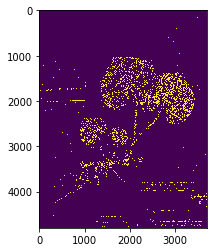

In [92]:
# FINDING ALL CONTOURS 
image = cv2.imread('leaf-ex-2.jpg')
image = image[1000:5800, 800:4500]

# Grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
# Find Canny edges 
edged = cv2.Canny(gray, 50, 100) 
plt.imshow(edged)

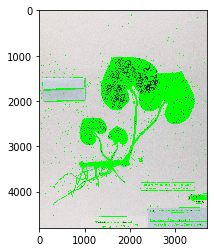

In [93]:
# Finding Contours 
# Use a copy of the image e.g. edged.copy() 
# since findContours alters the image 
contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

#plt.imshow(edged)

image = cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
plt.imshow(image)

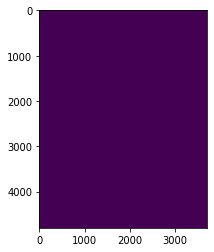

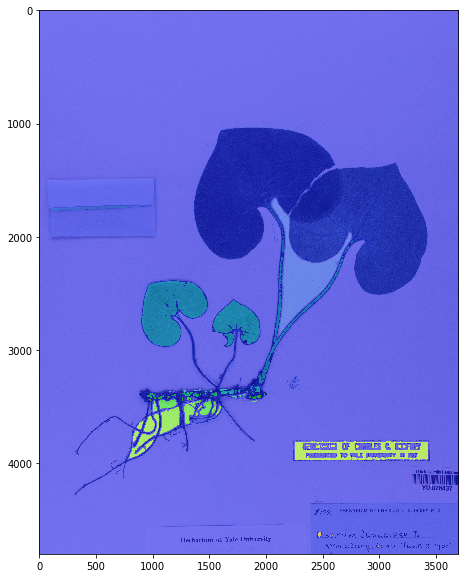

In [52]:
# FINDING CONTOURS BY WATERSHED
image = cv2.imread('leaf-ex-2.jpg')
image = image[1000:5800, 800:4500]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

kernel = np.ones((3, 3), np.uint8)
# sure background area
sure_bg = cv2.dilate(image, kernel, iterations=5)
opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
# Finding unknown region - not sure if this is actually useful - just purple
sure_fg = np.uint8(sure_fg)
# plt.imshow(sure_fg)

# sure_fg = cv2.erode(sure_fg,kernel,iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero

markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(labeled_img)

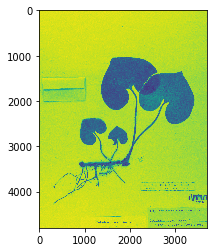

In [55]:
img2 = image.copy()
markers1 = markers.astype(np.uint8)
ret, m2 = cv2.threshold(markers1, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
cv2.imshow('m2', m2)
contours, hierarchy = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
for c in contours:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 2)

plt.imshow(img2)